*To delete before submit*

## Deadline

Wednesday, November 22, 2017, 11:59PM

## Important notes

- When you push your Notebook to GitHub, all the cells must already have been evaluated.
- Don't forget to add a textual description of your thought process and of any assumptions you've made.
- Please write all your comments in English, and use meaningful variable names in your code.

# 04 - Applied Machine Learning

In [93]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#define the default figure size for this notebook
plt.figure(figsize=(20,10))
plt.rcParams['figure.figsize']=(10,10)
%matplotlib inline

## Table of Contents

<div class="lev1"><a href="#Question-1:-Propensity-score-matching">
<span class="toc-item-num">1&nbsp;&nbsp;</span>Propensity score matching</a></div>
 <div class="lev2"><a href="#1.0-Loading-the-data">
 <span class="toc-item-num">1.0&nbsp;&nbsp;</span>Loading the data</a></div>
 <div class="lev2"><a href="#1.1-A-naive-analysis">
 <span class="toc-item-num">1.1&nbsp;&nbsp;</span>A naive analysis</a></div>
 <div class="lev2"><a href="#1.2-A-closer-look-at-the-data">
 <span class="toc-item-num">1.2&nbsp;&nbsp;</span>A closer look at the data</a></div>
 <div class="lev2"><a href="#1.3-A-propensity-score-model">
 <span class="toc-item-num">1.3&nbsp;&nbsp;</span>A propensity score model</a></div>
 <div class="lev2"><a href="#1.4-Balancing-the-dataset-via-matching">
 <span class="toc-item-num">1.4&nbsp;&nbsp;</span>Balancing the dataset via matching</a></div>
 <div class="lev2"><a href="#1.5-Balancing-the-groups-further">
 <span class="toc-item-num">1.5&nbsp;&nbsp;</span>Balancing the groups further</a></div>
 <div class="lev2"><a href="#1.6-A-less-naive-analysis">
 <span class="toc-item-num">1.6&nbsp;&nbsp;</span>A less naive analysis</a></div>

 
<div class="lev1"><a href="#Question-2:-Applied-ML"><span class="toc-item-num">2&nbsp;&nbsp;</span>Applied ML</a></div>

## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.


#### 1.0 Loading the data

In [2]:
data = pd.read_csv('lalonde.csv', index_col=0)
data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


#### 1.1 A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?



We first count the number of people in each group: the treated group and the non-treated one

In [3]:
print("number of people treat : %d" % (data['treat'] == 1).sum())
print("number of people not treat : %d" % (data['treat'] == 0).sum())
print("number of people : %d" % data.shape[0])

number of people treat : 185
number of people not treat : 429
number of people : 614


We now plot the boxplot:

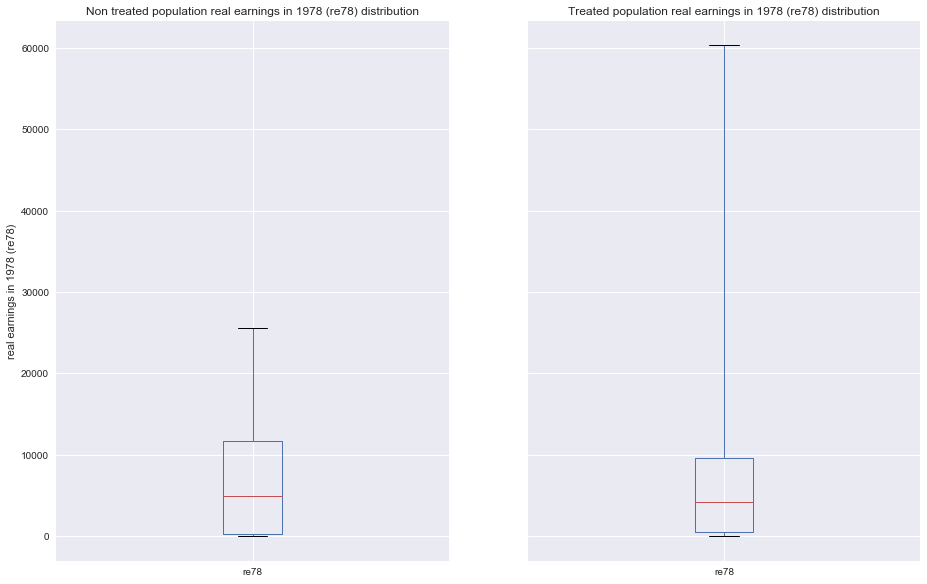

In [26]:
ax = data.groupby('treat').boxplot(figsize=(15,10), column='re78', whis=20)

ax[0].set_title('Non treated population real earnings in 1978 (re78) distribution')
ax[0].set_ylabel('real earnings in 1978 (re78)')
ax[1].set_title('Treated population real earnings in 1978 (re78) distribution');

At first view, the treated group seems to earn more money than the non-treated group in 1978, that is after the treatment.

Now, we will trace the distribution normalized by the number of people in each group:

In [28]:
re78 = data[['treat', 're78']].copy()
re78['cat'] = pd.cut(re78.re78,[x*1000 for x in range(0,31) ]+[70000]) #magic numbers?

x = re78.groupby(['cat','treat']).size().to_frame('occurences').reset_index()

x.loc[x['treat']==0,'occurences']/= x[x['treat']==0]['occurences'].sum() / 100
x.loc[x['treat']==1,'occurences']/= x[x['treat']==1]['occurences'].sum() / 100

In [29]:
#pick a seaborn colourblind colour palette
colorblind=['#0072B2','#D55E00', '#009E73', '#CC79A7', '#F0E442', '#56B4E9']
sns.set_palette(colorblind)

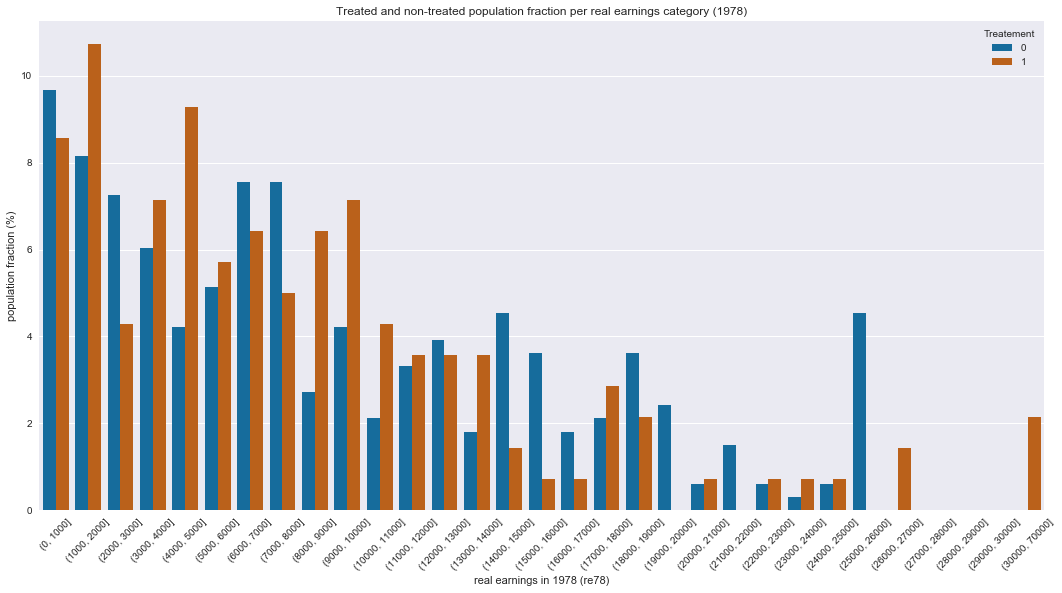

In [94]:
a4_dims = (18, 9)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=45)

ax = sns.barplot(ax=ax, x='cat', y='occurences', hue='treat', data=x)
ax.legend(loc='upper right', title='Treatement')

ax.set(title='Treated and non-treated population fraction per real earnings category (1978)',
       xlabel='real earnings in 1978 (re78)', ylabel='population fraction (%)');

The mean outcome in 1978 is higher for the non-treated group: this is explained in the distribution by the fact that in the non treated group, there is a non negligible number of people who earn between [24000, 25000] after the treatment, in 1978.

Here we trace the distribution like above but we add the Kernel density estimation (KDE), which is an estimation of the continuous distribution.
Since the KDE is an aproximationso, it has false negative value, but it helps to easily compare distribution nonetheless.

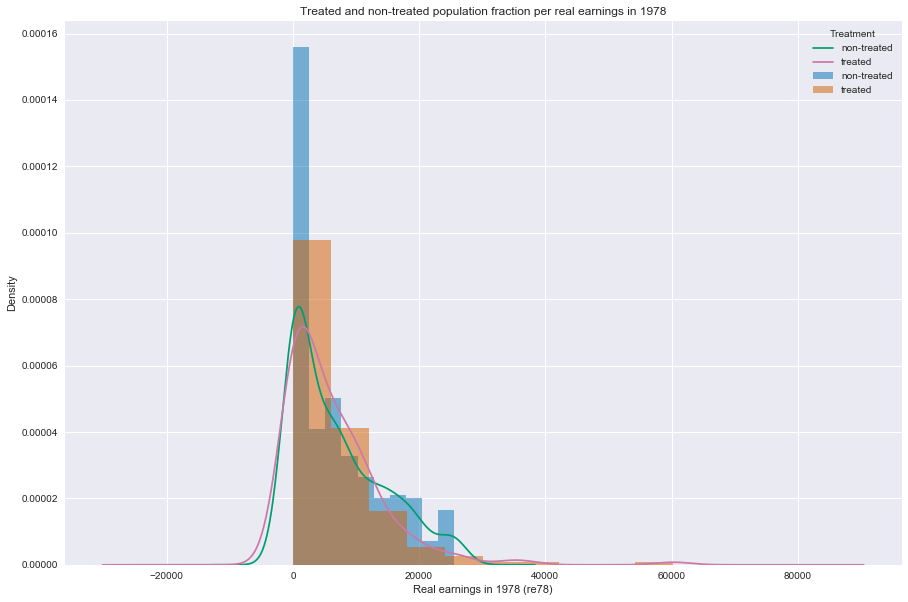

In [95]:
ax = data.groupby('treat')['re78'].plot.hist(figsize=(15,10),legend=True,normed=True,alpha=0.5)
ax[0].set_title('Treated and non-treated population fraction per real earnings in 1978')
ax[0].set_xlabel('Real earnings in 1978 (re78)')

ax = data.groupby('treat')['re78'].plot.kde(figsize=(15,10),legend=True)
ax[0].legend(title='Treatment', labels=['non-treated', 'treated','non-treated', 'treated'], loc='upper right');

Here we describe the distribution of both the treated and the non-treated groups using numbers:

In [100]:
# this function makes a pretty print output of describe() 
def compare_feature(re0, re1):
    tmp = pd.DataFrame()
    tmp['non treated'] = re0.reset_index(drop=True)
    tmp['treated'] = re1.reset_index(drop=True)
    return (tmp.describe())

#really necessary when have compare_feature()?
# this function makes a pretty print output of describe()
def compare_re78(re0, re1):
    return compare_feature(re0['re78'],re1['re78'])

#compare_re78(data.loc[data['treat'] == 0],data.loc[data['treat'] == 1])
compare_feature(data.loc[data['treat'] == 0]['re78'],data.loc[data['treat'] == 1]['re78'])

,non treated,treated
count,429.000000,185.000000
mean,6984.169742,6349.143530
std,7294.161791,7867.402218
min,0.000000,0.000000
25%,220.181300,485.229800
50%,4975.505000,4232.309000
75%,11688.820000,9642.999000
max,25564.670000,60307.930000


So in the end, using graphics and numbers, a naive conlusion can be that non-treated people earn a little more money than treated people.

#### 1.2 A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

So now we will observe the distribution of each feature (except the `treat` feature):

We first look at the distribution of the features using numbers, for both the treated group and the non-treated group:

In [41]:
data_treat = data.loc[data['treat'] == 1]
data_notreat = data.loc[data['treat'] == 0]
data_treat.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [42]:
data_notreat.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


Since these are hard to compare just by looking at them, we will use a graphical tool: histogram and Kernel density estimation (KDE) (which, recall, is just an estimation):

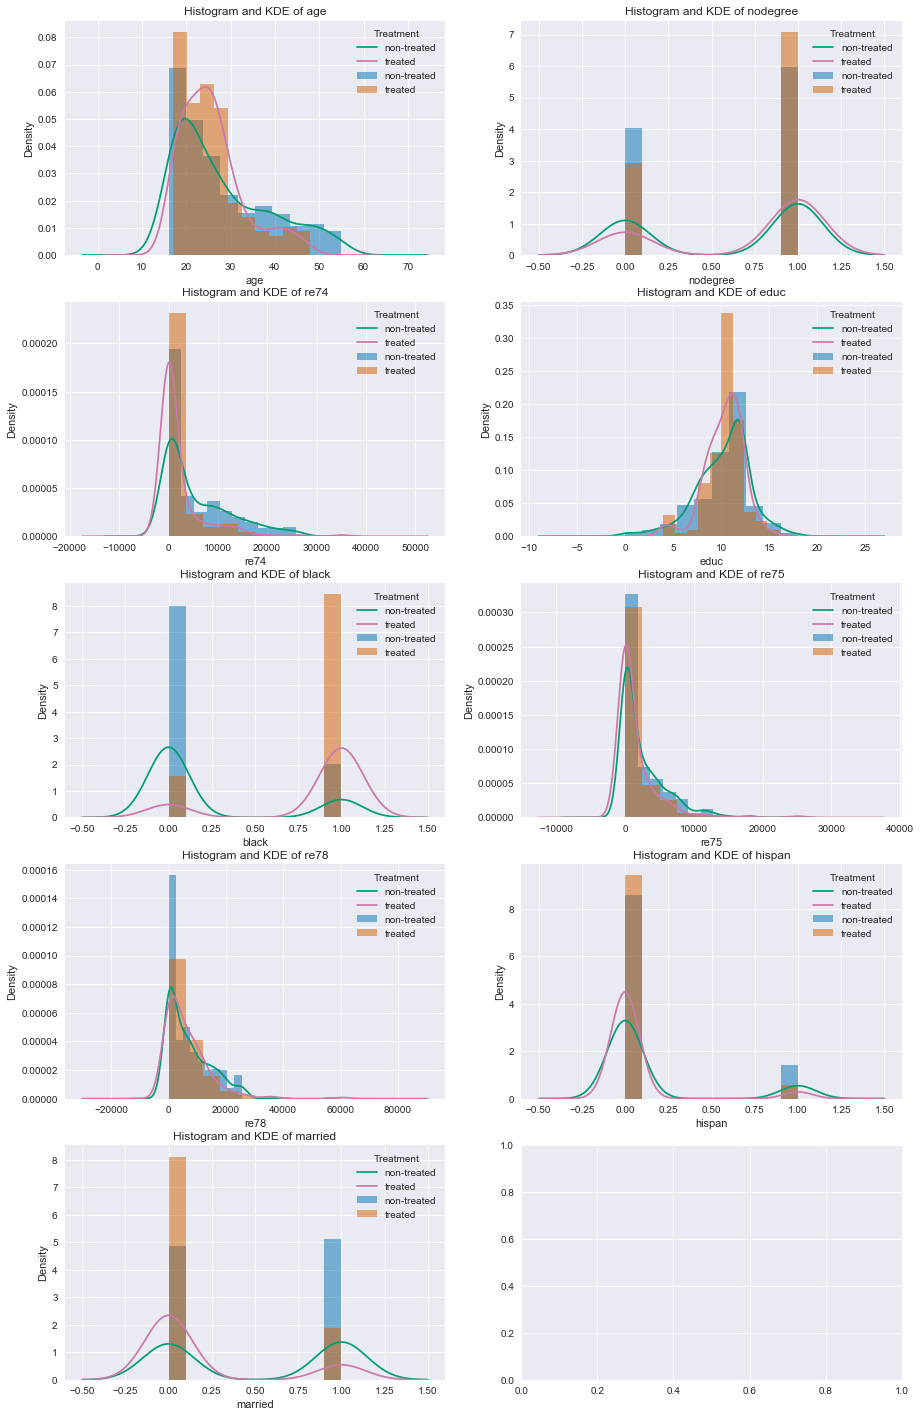

In [51]:
def density_hist_data(data):
    fig, axs = plt.subplots(5,2) #there are 9 feature, so we need 10 subplots (and an unsused one)
    #todo: is it possible to only display 9 subplots? and put some more (vertical) space between subplots?
    i=0
    
    for c in data.columns:
        if c not in 'treat':
            # this plots a normed histrogram, so that the scale is the same as for KDE
            ax1, ax2 = data.groupby('treat')[c].plot.hist(ax=axs[i%5,i%2], 
                                                          figsize=(15,25),
                                                          legend=True,
                                                          normed=True,
                                                          alpha=0.5)
            data.groupby('treat')[c].plot.kde(title="Histogram and KDE of "+c,
                                              ax=ax1,
                                              figsize=(15,25),
                                              sharey=False,
                                              legend=True)
            ax1.set_xlabel(c)
            ax1.legend(title='Treatment', labels=['non-treated', 'treated', 'non-treated', 'treated'], loc='upper right');
            i+=1        
            
density_hist_data(data)

Now, we clearly see that some variable are not equaly distributed in the two groups, treated and non-treated:
    - medium variation : 
        - age
        - re74
        - educ
        - hispan
    - high variation 
        - black
        - maried
    
So we cannot compare directly the non-treated and the treated group, since they do not represent the same sample of population.

#### 1.3 A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In this section, we will use logistic regression to obtain a propability that a person participates in the study (i.e receives the treatment).
This way, two people having a similar propability means that their features are close. 

In [52]:
logistic = LogisticRegression()

# remove treat and re78 from the data and use treat as output
logistic = logistic.fit(data[data.columns[1:-1]],data['treat'])

# save the prediction
data['p'] = logistic.predict_proba(data[data.columns[1:-1]])[:,1]

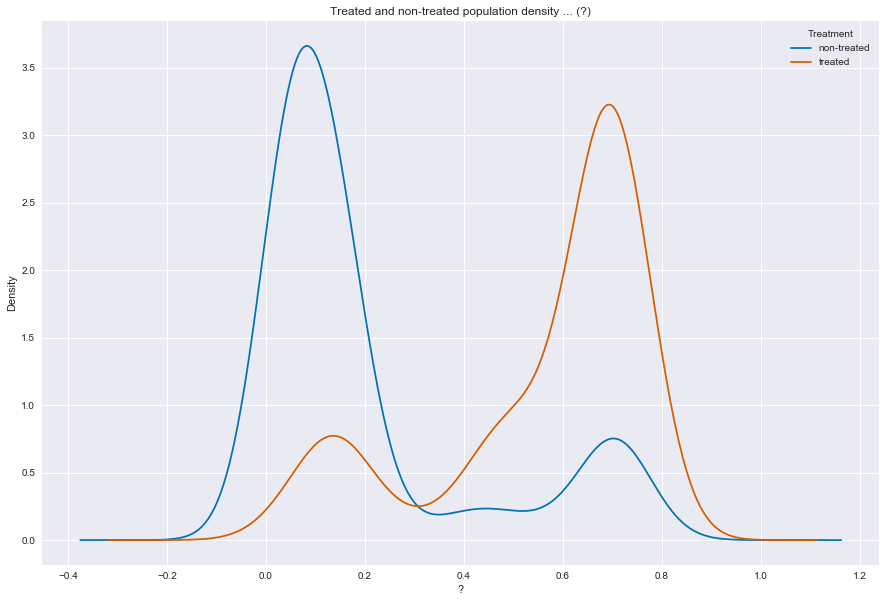

In [57]:
ax = data.groupby('treat')['p'].plot.density(figsize=(15,10),legend=True);

#todo: complete legend
ax[0].set_title('Treated and non-treated population density ... (?)')
ax[0].set_xlabel('?') #'probability of receiving the treatment'? 
ax[0].legend(title='Treatment', labels=['non-treated', 'treated'], loc='upper right');

This graph shows that a large fraction of people (highest blue peek) are not from the same population as the population of the treated people.

Fortunately, the second blue peek matches our treated population.
Therefore, we can pair each treated people with a non-treated people.

#### 1.4 Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In order to match a treated person with a non-treated one, we will use the K-Nearest Neighbours  method (KNN) with k = 1. 

In [62]:
def get_matching_pairs(data):

    data_treat = data.loc[data['treat'] == 1] # separe group : treat = train group for KNN
    data_notreat = data.loc[data['treat'] == 0] # not treat test group
    
    NN = NearestNeighbors(n_neighbors=1)# one neigborg , the nearest
    NN.fit(data_notreat['p'].values.reshape(-1, 1) )
    distances, indices = NN.kneighbors(data_treat['p'].values.reshape(-1, 1))# get the indice of the nearrest Neighbors
    indices = indices.reshape(indices.shape[0])
    matched = data_notreat.iloc[indices]# match treted with not treaded
    
    return matched

In [63]:
data_treat = data.loc[data['treat'] == 1]
data_notreat = get_matching_pairs(data) # matched not tread
print("Score(sum of abs(diff beetween treat and not tread pair )) :",np.abs(data_treat['p'].values-data_notreat['p'].values).sum())
data_matched = pd.concat([data_treat, data_notreat])

Score(sum of abs(diff beetween treat and not tread pair )) : 0.41124000465


For comparing the effect of features on both groups, we plot 9 different graphs, one per feature:

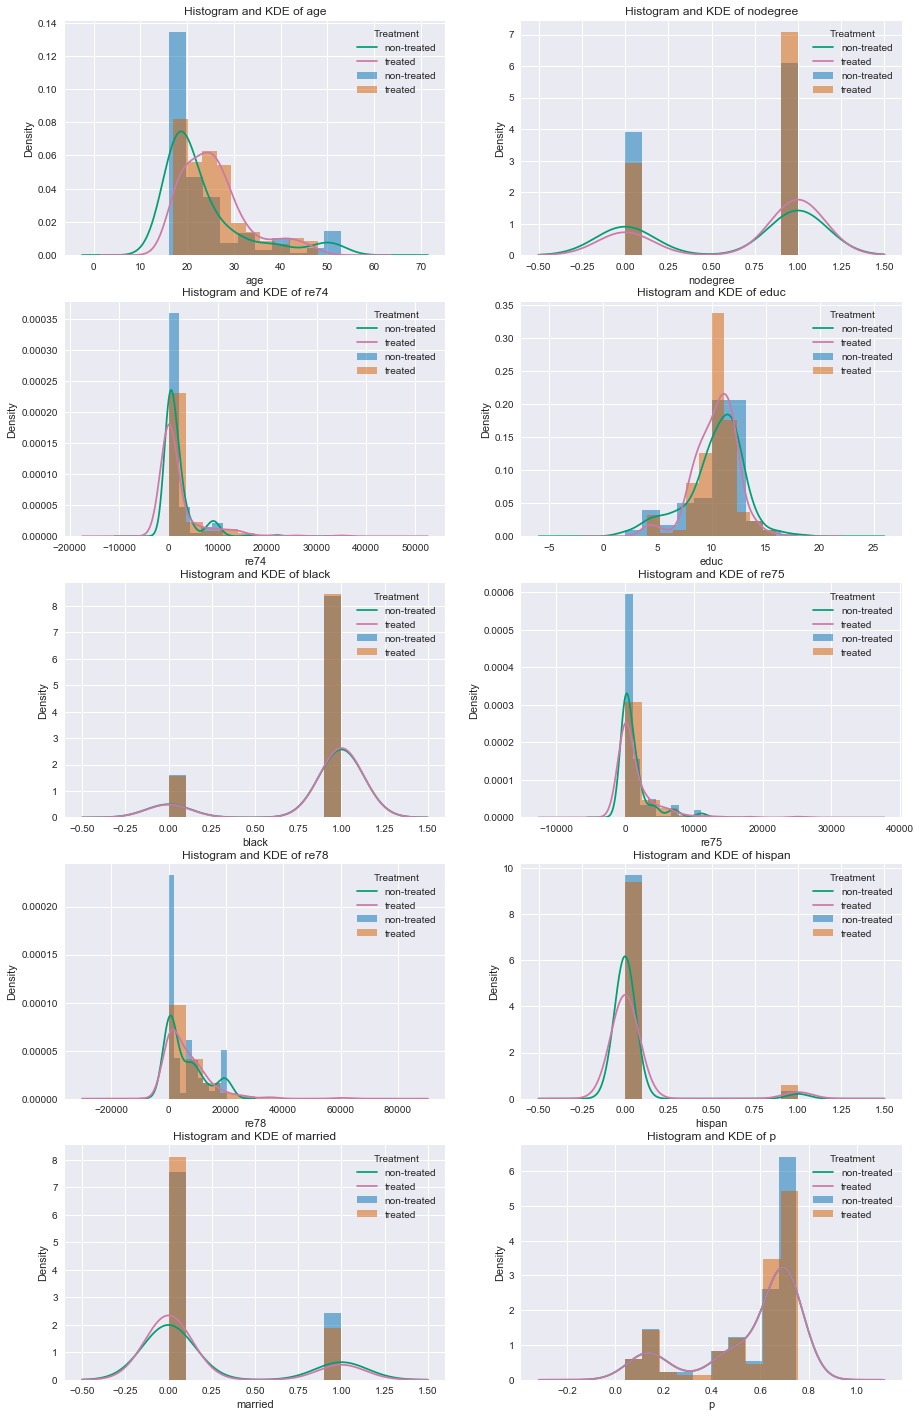

In [64]:
density_hist_data(data_matched)

Now we see that features are more balanced between the two groups.

However, the age, the real earing in 1975 (*re75*) and the education (*educ*) still do not seem very well balanced!

We therefore analyse these features:

In [65]:
compare_feature(data_notreat['age'], data_treat['age'])

,non treated,treated
count,185.000000,185.000000
mean,23.643243,25.816216
std,9.334501,7.155019
min,16.000000,17.000000
25%,18.000000,20.000000
50%,20.000000,25.000000
75%,25.000000,29.000000
max,53.000000,48.000000


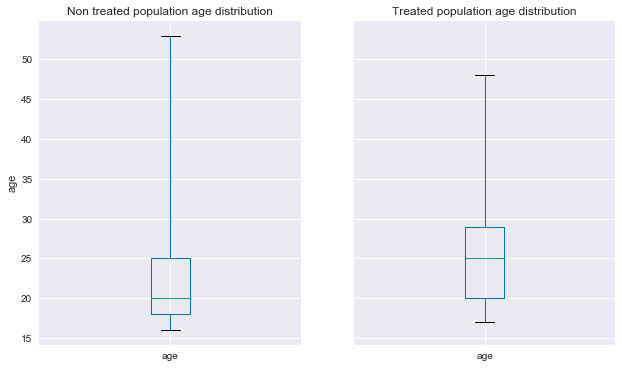

In [72]:
ax = data_matched.groupby('treat').boxplot(figsize=(10,6), column='age', whis=20)

ax[0].set_title('Non treated population age distribution')
ax[0].set_ylabel('age')
ax[1].set_title('Treated population age distribution');
#todo: what is that with the double x-label 'age'?

In [73]:
compare_feature(data_notreat['re75'], data_treat['re75'])

,non treated,treated
count,185.000000,185.000000
mean,1307.138718,1532.055314
std,2295.461224,3219.250870
min,0.000000,0.000000
25%,0.000000,0.000000
50%,245.274200,0.000000
75%,1623.823000,1817.284000
max,11105.370000,25142.240000


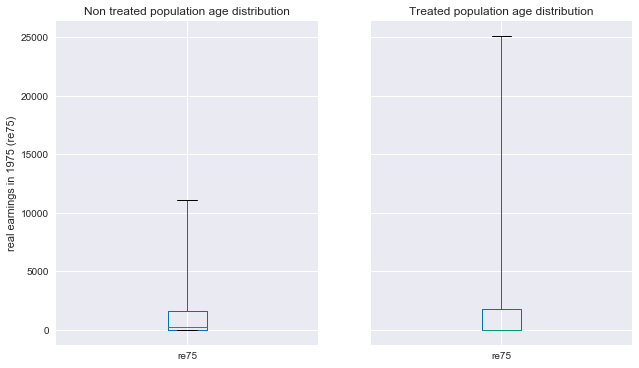

In [75]:
ax = data_matched.groupby('treat').boxplot(figsize=(10,6), column='re75', whis=20)

ax[0].set_title('Non treated population age distribution')
ax[0].set_ylabel('real earnings in 1975 (re75)')
ax[1].set_title('Treated population age distribution');
#todo: same as above

In [76]:
compare_feature(data_notreat['educ'], data_treat['educ'])

,non treated,treated
count,185.000000,185.000000
mean,10.281081,10.345946
std,2.706056,2.010650
min,2.000000,4.000000
25%,9.000000,9.000000
50%,11.000000,11.000000
75%,12.000000,12.000000
max,18.000000,16.000000


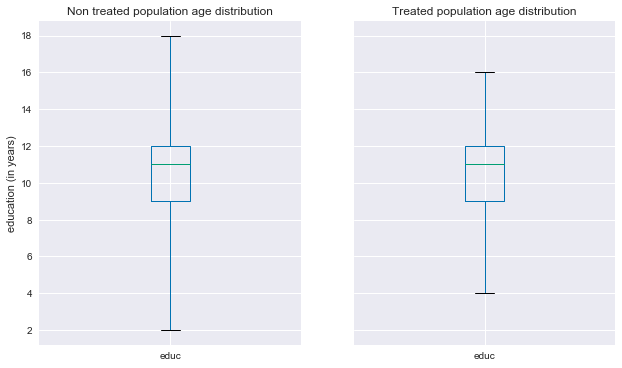

In [79]:
ax = data_matched.groupby('treat').boxplot(figsize=(10,6), column='educ', whis=20)

ax[0].set_title('Non treated population age distribution')
ax[0].set_ylabel('education (in years)')
ax[1].set_title('Treated population age distribution');
#todo: same as above

So it would seem that the features `age`, `educ` (education, in years) and `re75` (the real earnings in 1975) are not well balanced: one year of study or being slightly older (and hence, having more working experience) can significantly change the salary.

So we will now analyse the `re78` feature (real earnings in 1978):

In [80]:
compare_re78(data_notreat, data_treat)

,non treated,treated
count,185.000000,185.000000
mean,5867.022167,6349.143530
std,6781.554260,7867.402218
min,0.000000,0.000000
25%,0.000000,485.229800
50%,2404.261000,4232.309000
75%,9088.018000,9642.999000
max,20243.380000,60307.930000


Problem our algorithme matched 25% people who have not have a salary  kif there not in the treat group:
Maybe the treat prevent for unemployment.

*[... bliblabli what...?]*

So we observe a big improvement : 

In [88]:
print("improvment of "+str((data_treat.re78.mean()-data_notreat.re78.mean())/data_notreat.re78.mean()*100)+" % for mean")
print("improvment of "+str((data_treat.re78.median()-data_notreat.re78.median())/data_notreat.re78.median()*100)+" % for median")

improvment of 21.148894318794007 % for mean
improvment of 72.84656943804055 % for median


Now we can conclude that the salary improve effectively with this mathcing and balancing but we will improve it !

#### 1.5 Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

Now we want to balance the age in order to get a more accrurate study.

For this, we will use age in the NeirestNeighobrg to take of age and last salary: *(?)*

In [82]:
def get_matching_pairs_add_feature(data, force_of_age=1.0/10.0, force_of_re75=1/3.0):

    data_treat = data.loc[data['treat'] == 1]
    data_notreat = data.loc[data['treat'] == 0]
    
    feature  = lambda d : [d['p'].values,d['age'].values*force_of_age,d['educ'].values*force_of_re75] 
    
    data_notreat_feature = np.stack(feature(data_notreat) ,axis=1)
    data_treat_feature = np.stack(feature(data_treat) ,axis=1)

    NN = NearestNeighbors(n_neighbors=1)
    NN.fit(data_notreat_feature )
    distances, indices = NN.kneighbors(data_treat_feature)

    indices = indices.reshape(indices.shape[0])
    matched = data_notreat.iloc[indices]
    
    return matched

In [83]:
data_treat = data.loc[data['treat'] == 1]
data_notreat = get_matching_pairs_add_feature(data)
print(np.abs(data_treat['p'].values-data_notreat['p'].values).sum())
data_matched = pd.concat([data_treat,data_notreat])

14.6730713255


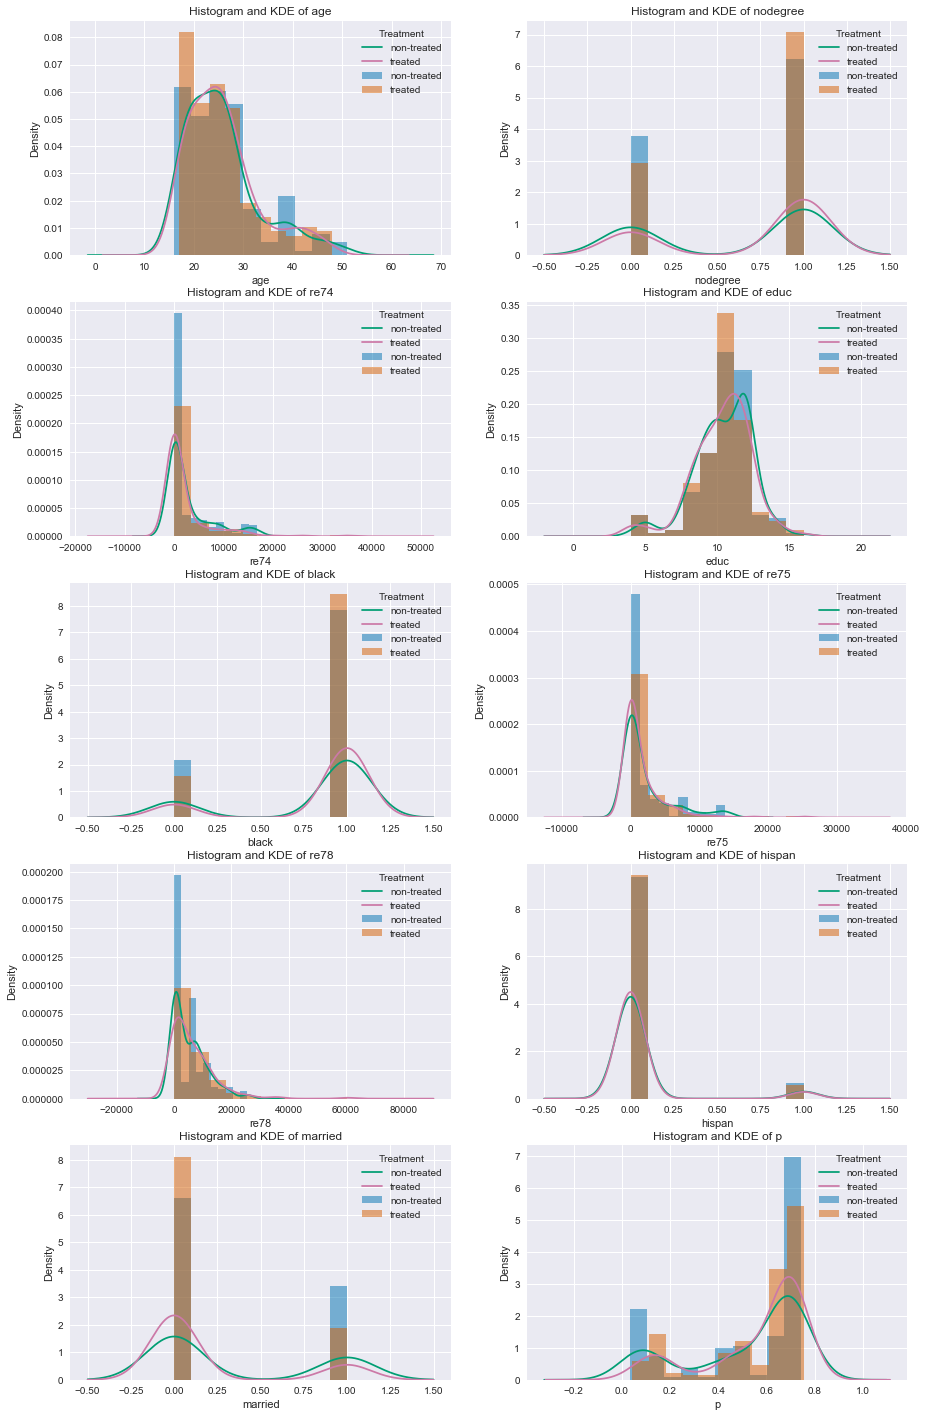

In [84]:
density_hist_data(data_matched)

When we force `age` and `educ` to be similar we have a better balancing in these two features. 

In [85]:
compare_feature(data_notreat['age'],data_treat['age'])

,non treated,treated
count,185.000000,185.000000
mean,25.718919,25.816216
std,7.538086,7.155019
min,16.000000,17.000000
25%,20.000000,20.000000
50%,24.000000,25.000000
75%,28.000000,29.000000
max,51.000000,48.000000


In [86]:
compare_feature(data_notreat['educ'], data_treat['educ'])

,non treated,treated
count,185.000000,185.000000
mean,10.454054,10.345946
std,1.969688,2.010650
min,4.000000,4.000000
25%,9.000000,9.000000
50%,11.000000,11.000000
75%,12.000000,12.000000
max,16.000000,16.000000


Now when we compare `re78` in the treated group and the non-treated group, ... *(something)*

In [214]:
compare_re78(data_notreat, data_treat)

,not treat,treat
count,185.000000,185.000000
mean,5240.777116,6349.143530
std,5838.763676,7867.402218
min,0.000000,0.000000
25%,54.675880,485.229800
50%,2448.593000,4232.309000
75%,7543.794000,9642.999000
max,25564.670000,60307.930000


In [87]:
print("improvment of "+str((data_treat.re78.mean()-data_notreat.re78.mean())/data_notreat.re78.mean()*100)+" % for mean")
print("improvment of "+str((data_treat.re78.median()-data_notreat.re78.median())/data_notreat.re78.median()*100)+" % for median")

improvment of 21.148894318794007 % for mean
improvment of 72.84656943804055 % for median


Now we can see improvement: a lot of people found a job after the treatment (median).

Also, the mean has an improvement of 21%.

#### 1.6 A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


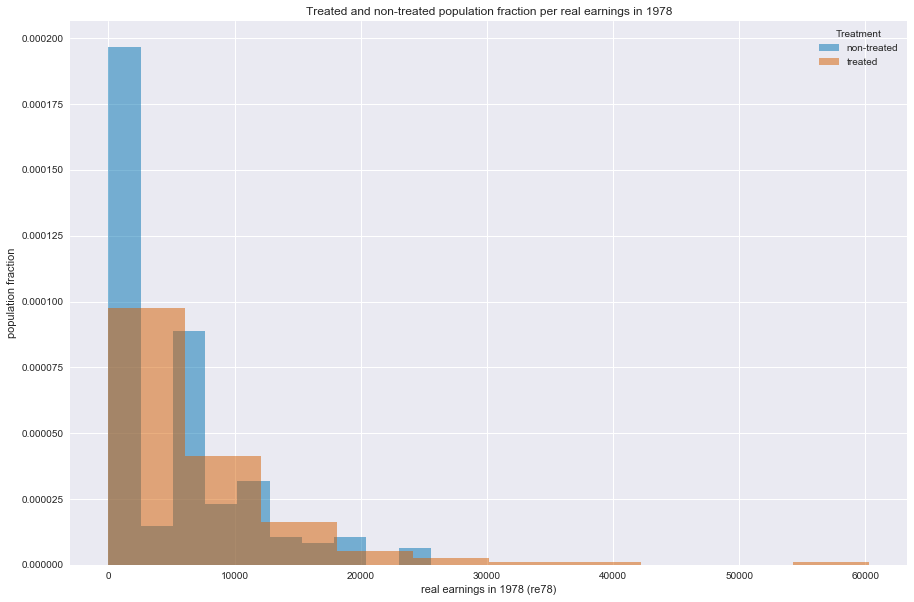

In [91]:
ax = data_matched.groupby('treat')['re78'].plot.hist(figsize=(15,10), legend=True, normed=True, alpha=0.5)
ax[0].set_title('Treated and non-treated population fraction per real earnings in 1978')
ax[0].set_ylabel('population fraction')
ax[0].set_xlabel('real earnings in 1978 (re78)')
ax[0].legend(title='Treatment', labels=['non-treated', 'treated'], loc='upper right');

In [92]:
compare_re78(data_notreat, data_treat)

,non treated,treated
count,185.000000,185.000000
mean,5240.777116,6349.143530
std,5838.763676,7867.402218
min,0.000000,0.000000
25%,54.675880,485.229800
50%,2448.593000,4232.309000
75%,7543.794000,9642.999000
max,25564.670000,60307.930000


Now we can say that the salary improves after the treatment in both groups that were pick under the assumptions of our balancing.

___

## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequencyâ€“inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.


In [219]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import itertools

In [220]:
newgroup = fetch_20newsgroups()

In [221]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newgroup.data)# vectorise

In [257]:
len(newgroup.data)
vectors.shape

(11314, 130107)

11314 articles, split in two group train(90%) and test(10%):

In [222]:
X_train, X_test, y_train, y_test = train_test_split(vectors, newgroup.target, test_size=0.1, random_state=1)
#_test, X_val, y_test, y_val  = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

Use grid search to find the best paramenter, we use a cross validation :

In [261]:
param_grid =   {'n_estimators': np.arange(135, 180,5), #todo a agrandir !!!
              'max_depth': np.arange(30, 45,3)
               }
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid=param_grid,n_jobs=-1,cv=3)
param = grid_search.fit(X_train, y_train)

In [262]:
grid_search.best_params_

{'max_depth': 42, 'n_estimators': 135}

Now, we use the best hyperparmeter found and data  to train our clasifier:

In [264]:
clf = RandomForestClassifier(max_depth = 55, n_estimators = 250)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=55, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Show the result:

In [267]:
cm = confusion_matrix(clf.predict(X_test),y_test)

Normalized confusion matrix
[[ 0.84313725  0.          0.          0.          0.          0.
   0.01960784  0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.01960784  0.
   0.11764706]
 [ 0.01538462  0.64615385  0.          0.04615385  0.03076923  0.06153846
   0.01538462  0.01538462  0.          0.01538462  0.          0.01538462
   0.01538462  0.03076923  0.03076923  0.06153846  0.          0.          0.
   0.        ]
 [ 0.          0.04411765  0.82352941  0.07352941  0.01470588  0.
   0.01470588  0.02941176  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.02941176  0.          0.79411765  0.05882353  0.01470588
   0.04411765  0.          0.          0.01470588  0.          0.
   0.02941176  0.          0.          0.          0.          0.
   0.01470588  0.        ]
 [ 0.          0.05454545  0.          0. 

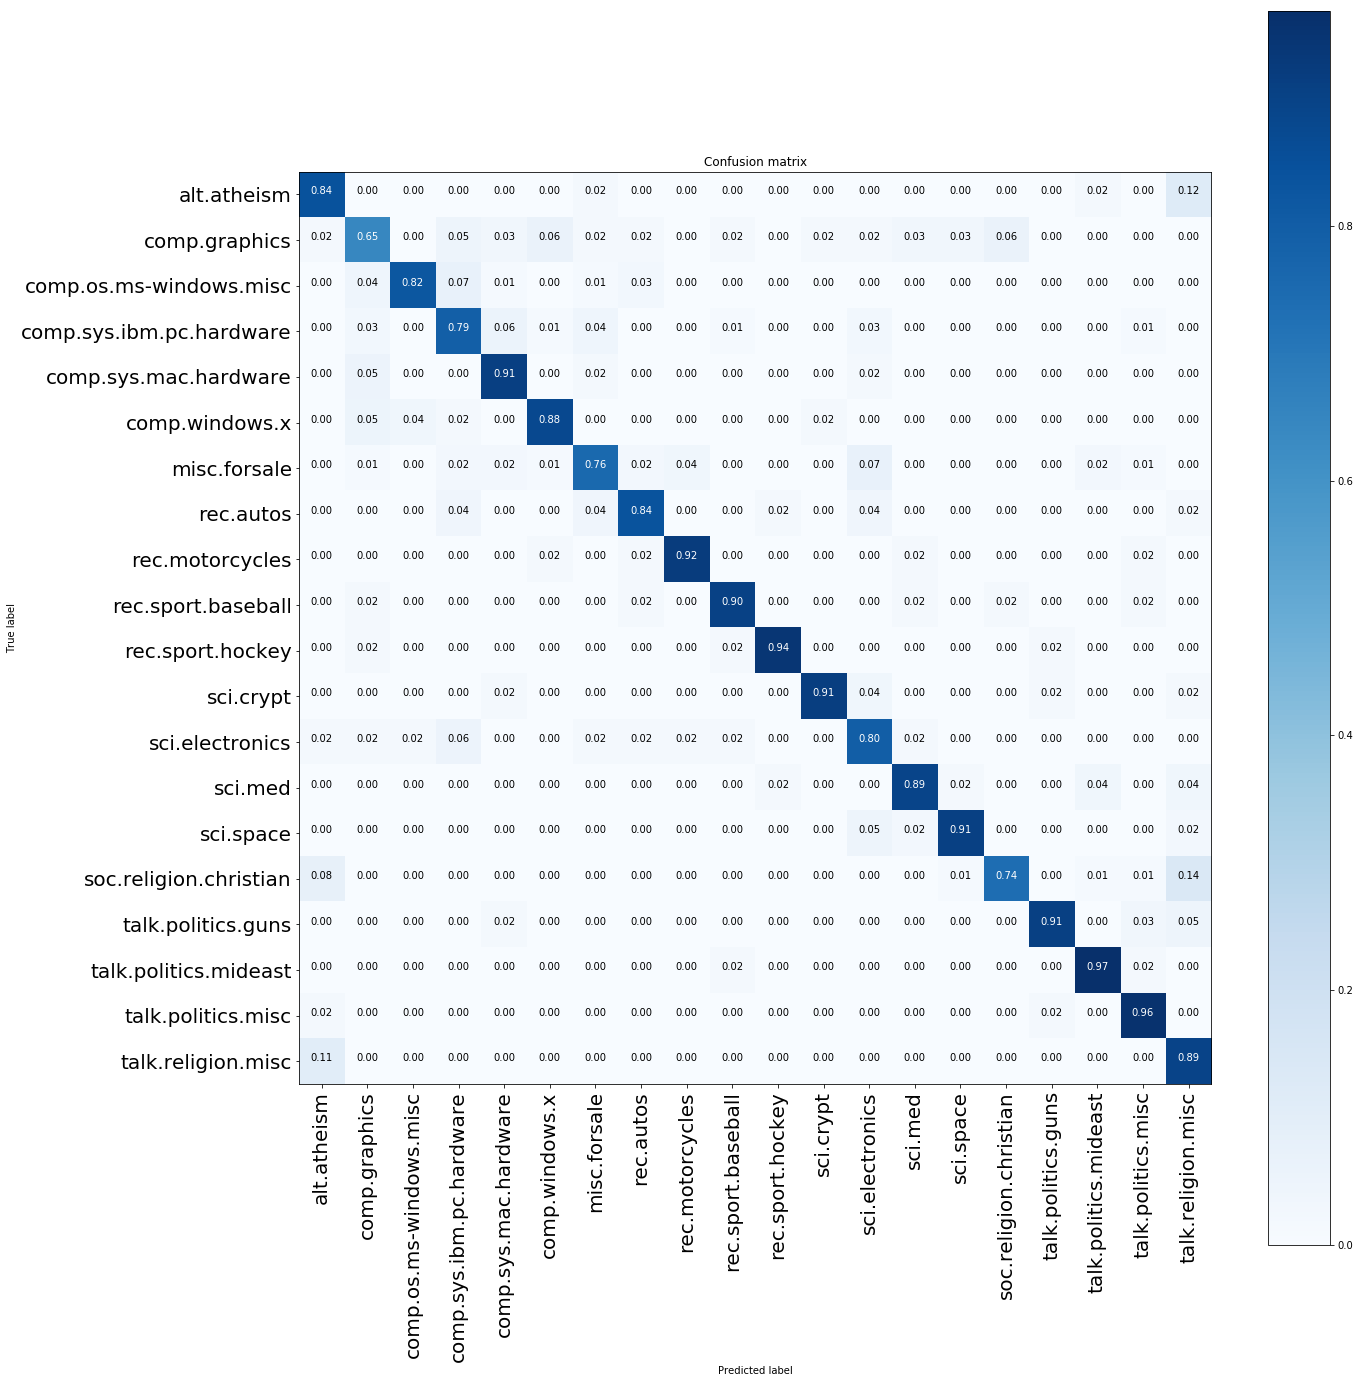

In [281]:
# from sklearn sample
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,size=20)
    plt.yticks(tick_marks, classes,size=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm,newgroup.target_names,True)

Good it seem that we ...

Feature ranking:
1. feature 124434 (0.005841)
2. feature 48421 (0.005386)
3. feature 40446 (0.005068)
4. feature 33301 (0.004871)
5. feature 104409 (0.004821)
6. feature 37780 (0.004544)
7. feature 63638 (0.004320)
8. feature 109061 (0.003759)
9. feature 31954 (0.003608)
10. feature 51591 (0.003591)


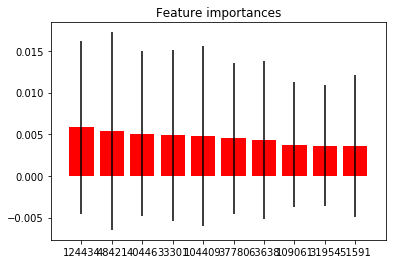

In [285]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][0:10]

# Print the feature ranking
print("Feature ranking:")

for f in range(0,10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,10), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(0,10), indices)
plt.xlim([-1, 10])
plt.show()

Work prety weel on test set 